!pip install crr_labels epigenomic_dataset \
 ucsc_genomes_downloader cache_decorator minepy &> /dev/null && echo "done"

In [1]:
!pip install crr_labels epigenomic_dataset extra_keras_metrics \
    keras_mixed_sequence keras_bed_sequence ucsc_genomes_downloader \
    cache_decorator minepy &> /dev/null && echo "done"
!pip install -Iv humanize==3.9.0 &> /dev/null && echo "done"
!pip install --upgrade tbb

done
done
Requirement already up-to-date: tbb in /usr/local/lib/python3.7/dist-packages (2021.2.0)


In [2]:
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
import seaborn as sbn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Retrive epigenomic data

In [4]:
cell_line = "K562"
genome_assembly = "hg38"
window_size = 256


aeie_X, aeie_y = active_enhancers_vs_inactive_enhancers(
    cell_line=cell_line,
    assembly=genome_assembly,
    window_size=window_size,
    root="/content/drive/MyDrive/bio-data/",
    verbose=1,
    binarize=True
)

#promoters_epigenomes, promoters_labels = load_epigenomes(
#    cell_line = cell_line,
#    dataset = "fantom",
#    region = "promoters",
#    window_size = window_size,
#    binarize = True
#)

#enhancers_epigenomes, enhancers_labels = load_epigenomes(
#    cell_line = cell_line,
#    dataset = "fantom",
#    region = "enhancers",
#    window_size = window_size,
#    binarize = True
#)

# Retrive genomic sequence

In [5]:
from ucsc_genomes_downloader import Genome

genome = Genome(
    "hg38",
    cache_directory="/content/drive/MyDrive/bio-data/genomes"
)

In [ ]:
genome

Human, Homo sapiens, hg38, 2013-12-27, 25 chromosomes

In [6]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [ ]:
aeie_X

In [ ]:
aeie_X.describe()

In [ ]:
aeie_y

In [ ]:
aeie_y.describe()

In [ ]:
epigenomes = {
    "promoters": promoters_epigenomes,
    "enhancers": enhancers_epigenomes,
}

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels,
}

In [ ]:
def describe_dataset(
    X: pd.DataFrame,
    y: pd.DataFrame
):
    """Perform a quick report for some relevant information in the dataset.

    Parameters
    ---------- 
    X: pd.DataFrame
        The dataframe to describe.
    y: pd.DataFrame
        The labels to describe.
    """
    print(X.describe())
    print(X[:5])
    print(y.describe())
    print(y[:5])
    print("="*30, "Feature Sample ration", "="*30)
    print(f"Features/Samples ratio is: {X.shape[0] / X.shape[1]}")
    print("="*30, "NaN count", "="*30)
    print(f"Total NaN values: {X.isna().values.sum()}/{X.values.size}")
    print(f"Max NaN in a row: {X.isna().sum(axis=1).max()}/{X.shape[1]}")
    print(f"Max NaN in a feature: {X.isna().sum().max()}/{X.shape[0]}")   

In [ ]:
for region, X in epigenomes.items():
   print(f"{region}") 
   describe_dataset(X, labels[region])
   print("|"*80)

In [7]:
def binarize(
    y: pd.DataFrame,
    cell_line: str
)-> pd.DataFrame:
    return y[cell_line].astype(int)

In [8]:
from sklearn.feature_selection import VarianceThreshold

def drop_constant_features(X: pd.DataFrame) -> (pd.DataFrame, bool):
    """Return a DataFrame without constant features in in.

    Parameters
    ----------------
    X: pd.DataFrame
        The dataframe to process.

    Returns
    ----------------
    A tuple with the new DataFrame and a boolean value to point out if the
    new DataFrame is distinct from the input one.
    """
    constant_feature_selector = VarianceThreshold()
    new_X = constant_feature_selector.fit_transform(X)
    return (new_X, new_X.shape[1] != X.shape[1])

In [9]:
def impute_with_median(X: pd.DataFrame) -> pd.DataFrame:
    return X.fillna(X.median())

In [10]:
from sklearn.preprocessing import RobustScaler

def robust_scaler(X: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        RobustScaler().fit_transform(X.values),
        columns=X.columns,
        index=X.index
    )

In [11]:
from typing import Tuple

def preprocess_dataset(
    X: pd.DataFrame,
    y: pd.DataFrame,
    region: str,
    cell_line: str,
    binary: bool=True
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    y_new = y
    if binary: 
        y_new[cell_line] = binarize(
            y_new,
            cell_line
        )
    X_new, ok = drop_constant_features(X)
    if not ok: 
        print(f"{region} doesn't have costant features.")
        X_new = X
    X_new = impute_with_median(X_new)
    return robust_scaler(X_new), y_new

In [12]:
#for region, X in epigenomes.items():
#    epigenomes[region] = preprocess_dataset(X, region)
    
aeie_X, aeie_y = preprocess_dataset(
    aeie_X,
    aeie_y,
    "aeie",
    cell_line,
    binary=True
)

aeie doesn't have costant features.


# Class balance

Active-Inactive ratio: 0.006376820812925387
Active fraction in dataset: 0.006336414632219325


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


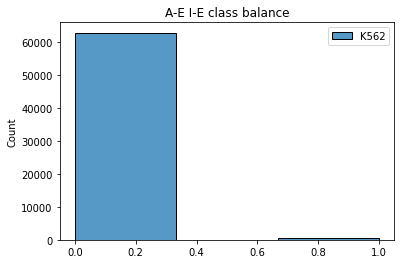

In [10]:
axes = sbn.histplot(
    data=aeie_y,
    bins=3
)

axes.set_title("A-E I-E class balance")

counts = aeie_y[cell_line].value_counts()
print(f"Active-Inactive ratio: {counts[1]/counts[0]}")
print(f"Active fraction in dataset: {counts[1]/(counts[0]+counts[1])}")

# Verify output correlation

In [ ]:
from scipy.stats import pearsonr

uncorrelated_features_with_output = {
    region: set()
    for region in epigenomes
}

for region, X in epigenomes.items():
    print("="*20, region.upper(), "="*20)
    for feature in tqdm(
        X.columns,
        desc=f"Running Person test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = pearsonr(
            X[feature].values.ravel(),
            labels[region].values.ravel()
        )
        if p_value > 0.01:
            print(f"Feature {feature} has no correlation with the output.")
            uncorrelated_features_with_output[region].add(feature)

print(uncorrelated_features_with_output)

In [ ]:
from scipy.stats import spearmanr

for region, X in epigenomes.items():
    print("="*20, region.upper(), "="*20)
    for feature in tqdm(
        X.columns,
        desc= f"Running Spearman test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = spearmanr(
            X[feature].values.ravel(),
            labels[region].values.ravel()
        )
        if p_value > 0.01:
            print(f"Feature {feature} has no correlation with the output {correlation}.")
            uncorrelated_features_with_output[region].add(feature)

print(uncorrelated_features_with_output)

In [ ]:
from minepy import MINE

for region, X in epigenomes.items():
    for feature in tqdm(
        uncorrelated_features_with_output[region],
        desc = f"Running MINE test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        mine = MINE()
        mine.compute_score(
            X[feature].values.ravel(),
            labels[region].values.ravel()
        )
        score = mine.mic()
        if score >= 0.05:
            uncorrelated_features_with_output[region].remove(feature)
        else:
            print(region, feature, score)

print(uncorrelated_features_with_output)

In [ ]:
for region, X in epigenomes.items():
    epigenomes[region] = X.drop(columns=[
        c
        for c in uncorrelated_features_with_output[region]
        if c in X.columns                     
    ])

In [ ]:
for _, X in epigenomes.items():
    print(X.shape)

# Feature Correlation

In [ ]:
from scipy.stats import entropy
from typing import List

def features_correlation(
    X: pd.DataFrame,
    p_value_threshold: float = 0.01,
    correlation_threshold: float = 0.95
) -> List:
    scores = []

    for i, feature_1 in tqdm(
        enumerate(X.columns),
        total = len(X.columns),
        desc = f"Running tests for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        for feature_2 in X.columns[i+1:]:
            correlation, p_value = pearsonr(
                X[feature_1].values.ravel(),
                X[feature_2].values.ravel()
            )
            scores.append((correlation, feature_1, feature_2))
    #        if p_value < p_value_threshold and np.abs(correlation) > correlation_threshold:
    #            print(f"High correlation (Pearson): {feature_1} with {feature_2} ({correlation})")
    #            if entropy(X[feature_1]) > entropy(X[feature_2]):
    #                high_correlation[region].add(feature_2)
    #            else:
    #                high_correlation[region].add(feature_1)
    
    return scores

In [ ]:
result = {}

for region, X in epigenomes.items():
    result[region] = features_correlation(X, region)

In [ ]:
scores = {
    region: sorted(score, 
                   key=lambda x: np.abs(x[0]), 
                   reverse=True)
    for region, score in result.items()
}

In [ ]:
for region, X in epigenomes.items():
    # take the first three elems, unwrap them and then merge togheter
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")
    sbn.pairplot(pd.concat([
        X[columns],
        labels[region],
    ], axis=1), hue=labels[region].columns[0])
    plt.show()

# Feature selection

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

for region, X in epigenomes.items():
    print(f"Feature selection for {region}")
    clf = ExtraTreesClassifier(
        n_estimators=50,
        max_depth=10
    )
    clf.fit(X, labels[region].values.ravel())
    model = SelectFromModel(clf, prefit=True)
    X_new = pd.DataFrame(
        model.transform(X),
        columns=X.columns[model.get_support()],
        index=X.index
    )
    print(f"new shape: {X_new.shape}")
    epigenomes[region] = X_new

# Data visualization

In [ ]:
from sklearn.decomposition import PCA

def pca_decomposition(
    X: np.ndarray,
    components: int = 2
) -> np.ndarray:
    return PCA(n_components=components).fit_transform(X)
#        index=X.index,
#        columns=X.columns,

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE

@Cache(
    cache_path="decomposition/tsne/{task}/{perplexity}_{dimensionality_threshold}_{_hash}.pkl.gz",
    args_to_ignore=["X"]
)
def tsne_decomposition(
    X:np.ndarray,
    perplexity:int,
    task:str,
    dimensionality_threshold:int=50,
) -> np.ndarray:
    if X.shape[1] > dimensionality_threshold:
        X = pca_decomposition(X, components=dimensionality_threshold)
    return TSNE(
        perplexity=perplexity,
        n_jobs=cpu_count(),
        random_state=42
    ).fit_transform(X)

In [ ]:
pca_dec = pca_decomposition(aeie_X.values)
_ = sbn.scatterplot(
    x=pca_dec.T[0],
    y=pca_dec.T[1],
    hue=aeie_y[cell_line]
)

In [ ]:
dec = tsne_decomposition(
    aeie_X.values, 
    perplexity=30,
    task="aeie",
    dimensionality_threshold=50
)
_ = sbn.scatterplot(
    x=dec.T[0],
    y=dec.T[1],
    hue=aeie_y[cell_line]
)

# Model creation

In [13]:
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from extra_keras_metrics import get_complete_binary_metrics, get_standard_binary_metrics,get_minimal_multiclass_metrics
from keras_mixed_sequence import MixedSequence, VectorSequence
from tqdm.keras import TqdmCallback

In [34]:
def build_fixed_ffnn(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(256, activation="relu")(input_epigenomic_data)
    hidden = Dense(128, activation="relu")(hidden)
    hidden = Dense(64, activation="relu")(hidden)
    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryFixedFFNN"
    )

    ffnn.compile(
        optimizer=SGD(
            learning_rate=0.1
        ),
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

In [39]:
def build_fixed_cnn(
    window_size: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = BatchNormalization()(input_sequence_data)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)

    for _ in range(2):
        hidden = BatchNormalization()(hidden)
        hidden = Conv1D(
            64,
            kernel_size=5,
            activation="relu"
        )(hidden)
        
    hidden = MaxPool1D(pool_size=2)(hidden)

    hidden = Conv1D(
            64,
            kernel_size=10,
            activation="relu"
        )(hidden)
    
    hidden = MaxPool1D(pool_size=2)(hidden)
    
    hidden = Flatten()(hidden)
    hidden = Dense(64, activation="relu")(hidden)
    hidden = Dropout(rate=0.1)(hidden)
    hidden = Dense(64, activation="relu")(hidden)
    last_hidden_cnn = Dropout(rate=0.1)(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="BinaryClassificationCNN"
    )

    cnn.compile(
        optimizer=Nadam(
            learning_rate=0.002,
        ),
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )

    return cnn, input_sequence_data, last_hidden_cnn

In [33]:
from typing import Optional

def build_binary_classification_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    The created model.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_fixed_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_fixed_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_minimal_multiclass_metrics()
    )

    return mmnn

In [17]:
from keras_bed_sequence import BedSequence

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [18]:
from tensorflow.keras.callbacks import EarlyStopping


@Cache(
    cache_path=[
        "/content/drive/MyDrive/bio-data/model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.gz",
        "/content/drive/MyDrive/bio-data/model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.gz",
    ],
    args_to_ignore=[
        "model", "train_sequence", "test_sequence"
    ]
)
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int,
    epochs: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    train_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=epochs,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=1e-3,
                patience=2,
                mode="min"
            ),
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

n_splits = 2
test_size = 0.2
random_state = 9012

stratified_split = StratifiedShuffleSplit(
    n_splits = n_splits,
    test_size = test_size,
    random_state = random_state
)

In [36]:
training_history = {}

all_performance_history = []

bed = to_bed(aeie_X)
n_features = aeie_X.shape[1]

task_name = "aeie"
training_history[task_name] = []

for holdout_number, (train_indices, test_indices) in tqdm(
    enumerate(stratified_split.split(aeie_X, aeie_y)),
    total=n_splits,
    leave=False,
    desc="Computing holdouts"
):
    # train and test set
    train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
    train_X, test_X = aeie_X.iloc[train_indices], aeie_X.iloc[test_indices]
    train_y, test_y = aeie_y.iloc[train_indices], aeie_y.iloc[test_indices]
    
    train_y = train_y.values.flatten()
    test_y = test_y.values.flatten()
    train_X = train_X.values
    test_X = test_X.values

    # creation of the models
    ffnn, input_epigenomic_data, last_hidden_ffnn = build_fixed_ffnn(n_features)
    cnn, input_sequence_data, last_hidden_cnn = build_fixed_cnn(n_features)
    mmnn1 = build_binary_classification_mmnn(n_features, window_size)
    mmnn2 = build_binary_classification_mmnn(
        input_sequence_data=input_sequence_data,
        input_epigenomic_data=input_epigenomic_data,
        last_hidden_ffnn=last_hidden_ffnn,
        last_hidden_cnn=last_hidden_cnn
    )
    #if holdout_number == 0: 
    #    cnn.summary()
    #    ffnn.summary()
    #    mmnn1.summary()
    #    mmnn2.summary()

    # loop to train all the models
    for model, train_seq, test_seq in tqdm((
        (ffnn, 
         get_ffnn_sequence(train_X, train_y, batch_size=32), 
         get_ffnn_sequence(test_X, test_y, batch_size=32)
        ),
        (cnn, 
         get_cnn_sequence(genome, train_bed, train_y, batch_size=100), 
         get_cnn_sequence(genome, test_bed, test_y, batch_size=100)
        ),
        (mmnn1,
         get_mmnn_sequence(genome, train_bed, train_X, train_y), 
         get_mmnn_sequence(genome, test_bed, test_X, test_y)
        ),
        (mmnn2,
         get_mmnn_sequence(genome, train_bed, train_X, train_y),
         get_mmnn_sequence(genome, test_bed, test_X, test_y)
        ),
    )):
        history, performance = train_model(
            model,
            model.name,
            task_name,
            cell_line,
            train_seq,
            test_seq,
            holdout_number,
            epochs=64
        )
        training_history[task_name].append(history)
        all_performance_history.append(performance)

all_performance_history = pd.concat(all_performance_history)

In [37]:
all_performance_history

,loss,accuracy,recall,precision,AUROC,AUPRC,run_type,model_name,task,holdout_number,f1_score,balanced_accuracy,specificity,miss_rate,fall_out,mcc,tp/t,fp/t,tn/t,fn/t,negative_predictive_value,false_discovery_rate,false_omission_rate,prevalence_threshold,threat_score,fowlkes_mallows_index,informedness,markedness,LR_pos,LR_neg,DOR
0,0.038455,0.993660,0.000000,0.000000,0.501325,0.006357,train,BinaryFixedFFNN,aeie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.038364,0.993679,0.000000,0.000000,0.496414,0.006276,test,BinaryFixedFFNN,aeie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.038249,0.993660,0.000000,0.000000,0.500000,0.006340,train,BinaryClassificationCNN,aeie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.038166,0.993679,0.000000,0.000000,0.500000,0.006321,test,BinaryClassificationCNN,aeie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.058814,0.988978,0.327103,0.234899,0.907451,0.157183,train,MMNN,aeie,0,0.273438,0.660152,0.993202,0.672897,0.006798,0.271773,0.002074,0.006755,0.986905,0.004266,0.995696,0.765101,0.004304,0.125999,0.158371,0.660152,0.277193,0.230595,48.114967,0.677503,1.942494
1,0.064536,0.986174,0.225000,0.137405,0.830705,0.095159,test,MMNN,aeie,0,0.170616,0.608008,0.991015,0.775000,0.008985,0.169152,0.001422,0.008928,0.984752,0.004898,0.995050,0.862595,0.004950,0.166548,0.093264,0.608008,0.175830,0.132455,25.042421,0.782026,1.551070
0,0.011261,0.994272,0.161994,0.712329,0.997505,0.687564,train,BoostedMMNN,aeie,0,0.263959,0.580788,0.999583,0.838006,0.000417,0.337988,0.001027,0.000415,0.993245,0.005313,0.994679,0.287671,0.005321,0.048309,0.152047,0.580788,0.339695,0.707008,387.974701,0.838356,1.385429
1,0.053328,0.993363,0.025000,0.250000,0.756274,0.071175,test,BoostedMMNN,aeie,0,0.045455,0.512261,0.999523,0.975000,0.000477,0.077327,0.000158,0.000474,0.993205,0.006163,0.993833,0.750000,0.006166,0.121374,0.023256,0.512261,0.079057,0.243833,52.393185,0.975465,1.050279
0,0.038408,0.993660,0.000000,0.000000,0.500000,0.006340,train,BinaryFixedFFNN,aeie,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.038308,0.993679,0.000000,0.000000,0.500000,0.006321,test,BinaryFixedFFNN,aeie,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


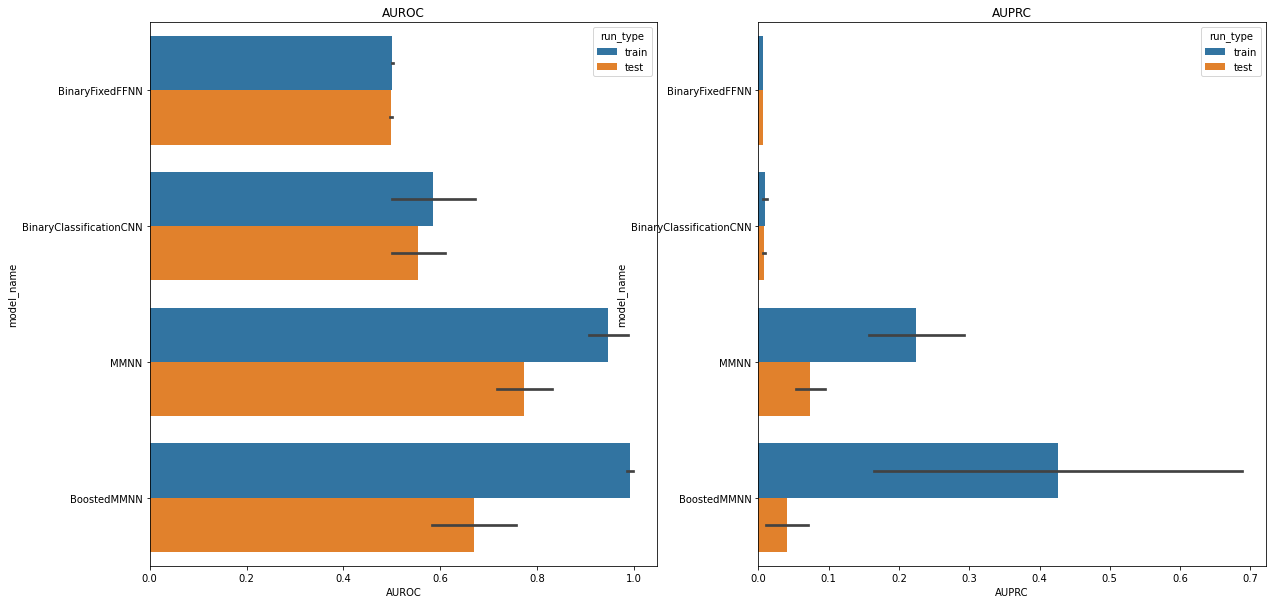

In [38]:
_, axs = plt.subplots(ncols=2, figsize=(20, 10))
sbn.barplot(
    x="AUROC",
    y="model_name",
    data=all_performance_history,
    hue="run_type",
    orient="h",
    ax=axs[0],
    ci="sd"
)
axs[0].set_title("AUROC")

sbn.barplot(
    x="AUPRC",
    y="model_name",
    data=all_performance_history,
    hue="run_type",
    orient="h",
    ax=axs[1]
)
_ = axs[1].set_title("AUPRC")